In [6]:
project_root = "/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn"

In [7]:
import os
import sys

# Define the project root path
current_wd = os.getcwd()

# Change the working directory if necessary
if current_wd != project_root:
    print(f"Changing working directory from {current_wd} to {project_root}")
    os.chdir(project_root)
else:
    print("Already in the correct path")

# Add 'src' directory to sys.path
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    print(f"Adding {src_path} to sys.path")
    sys.path.insert(0, src_path)

Changing working directory from /mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/src/eda to /mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn
Adding /mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/src to sys.path


In [13]:
import pandas as pd
from utils.logger import get_logger
from data_gathering import data_gathering
import sys
import os

In [10]:
logger = get_logger("first_model")

First we want to explain what we want to do:
 - We want to get the data from January to October 2022 to see how the model works
 - We will split the data as 7 months for training and 2 for testing
 - We will only ose a low percentatge of data in the dataset.
 - We will select this low percentage of data by users, selecting a random set of users at the begining and using those users through the months
 - We will not compute any variables, we will use the ones already computed in BQ and the variables from that month
 - The target predicted will be the customers churned in the month + 2
 - We will compute this target in BQ to test if the model is handling correctly


In [121]:
MONTHS = ["01", "02", "03", "05", "06", "07", "08", "09", "10"]
TRAIN_MONTHS = ["01", "02", "03", "05", "06", "07", "08"]
TEST_MONTHS = ["09", "10"]

In [19]:
def get_hole_month_df(month: str) -> pd.DataFrame:
    month_target = str(int(month) + 2).zfill(2)
    sql_get_users_data = f"""
            WITH target as (
                SELECT customer_id, MONTH, NUM_DAYS_LINE_TYPE_FIXE_POST_DEA
                FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
            )

            SELECT distinct
            c.customer_id, c.MONTH, YEAR, pago_final_0, dif_pago_final_prev_month, dif_pago_final_prev_2_month, dif_pago_final_prev_3_month, periodica_0, dif_periodica_prev_month, dif_periodica_prev_2_month, 
            dif_periodica_prev_3_month, consumo_0, dif_consumo_prev_month, dif_consumo_prev_2_month, dif_consumo_prev_3_month, aperiodica_0, dif_aperiodica_prev_month, 
            dif_aperiodica_prev_2_month, dif_aperiodica_prev_3_month, discount_0, dif_discount_prev_month, dif_discount_prev_2_month, dif_discount_prev_3_month, ajuste_0, 
            dif_ajuste_prev_month, dif_ajuste_prev_2_month, dif_ajuste_prev_3_month, Tota_Compra_disp, Curr_Compra_disp, Curr_Compra_Finanz_disp, Curr_Finanz_disp, Month_purchase_disp, Modelo_disp, Import_Rest_quota_disp, pvp_total_disp, pvp_total_disp_movil, Curr_cancel_disp, Tota_cancel_disp
            NUM_GB_OWNN_CURR, NUM_GB_2G_CURR, NUM_GB_3G_CURR, NUM_GB_4G_CURR, NUM_GB_5G_CURR, NUM_SESS_CURR, NUM_SECS_CURR, NUM_CALL_CURR, NUM_CALL_WEEK_CURR, NUM_CALL_WEEKEND_CURR, 
            NUM_SECS_WEEK_CURR, NUM_SECS_WEEKEND_CURR, NUM_CALL_WEEK, NUM_CALL_WEEKEND, t.NUM_DAYS_LINE_TYPE_FIXE_POST_DEA as target
            FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022` as c
            INNER JOIN `ESTIMACION_CHURN.selected_customers_first_iteration` as sc
            ON c.customer_id = sc.customer_id
            INNER JOIN target as t
            ON t.customer_id = c.customer_id and t.MONTH = "{month_target}"
            WHERE IS_CUST_SEGM_RESI > 0 
            AND IS_CUST_BILL_POST_CURR = TRUE
            AND CUST_BUNDLE_CURR = 'FMC'
            AND NUM_IMPAGOS = 0
            AND pago_final_0 IS NOT NULL
            AND c.MONTH = "{month}"
            ORDER BY c.customer_id
        """
    
    return data_gathering(sql_get_users_data)

In [21]:
def treat_target(target_col: pd.Series) -> pd.Series:
    return target_col.clip(upper=1).fillna(0)

In [20]:
january_customer_data = get_hole_month_df("01")

In [23]:
january_customer_data["target"] = treat_target(january_customer_data["target"])

Check if the dataset is balanced or not

In [94]:
n_of_1_target = january_customer_data.loc[january_customer_data["target"] == 1][
    "target"
].count()
n_of_0_target = january_customer_data.loc[january_customer_data["target"] == 0][
    "target"
].count()

logger.info(
    f"The dataset is not balanced as we can see, we have {n_of_1_target} of customers churned (positive) vs {n_of_0_target} of customers not churned (negative) with rate {n_of_1_target/n_of_0_target}"
)

INFO - The dataset is not balanced as we can see, we have 1198 of customers churned (positive) vs 21734 of customers not churned (negative) with rate 0.05512100855801969


In [46]:
# The customer_id, month and year columns should not be used when training
january_customer_data = january_customer_data.drop(["customer_id", "MONTH", "YEAR"], axis=1)

Before splitting and training the data we should be careful with the NaNs in the dataframe and treat them carefully

In [48]:
def assess_NA(data: pd.DataFrame):
    """
    Returns a pd.DataFrame denoting the total number of NA
    values and the percentage of NA values in each column.
    """
    # pd.Datadenoting features and the sum of their null values
    nulls = data.isnull().sum().reset_index().rename(columns={0: "count"})
    nulls["percent"] = nulls["count"] * 100 / len(data)

    return nulls

nans_df = assess_NA(january_customer_data)

In [78]:
na_info_sorted = nans_df.sort_values(by="percent", ascending=False)
na_info_sorted.head(20)

,index,count,percent
30,Import_Rest_quota_disp,17396,75.855754
28,Month_purchase_disp,14563,63.502376
29,Modelo_disp,14563,63.502376
32,pvp_total_disp_movil,14563,63.502376
31,pvp_total_disp,14253,62.150613
24,Tota_Compra_disp,13906,60.637509
25,Curr_Compra_disp,13906,60.637509
27,Curr_Finanz_disp,13906,60.637509
33,Curr_cancel_disp,13906,60.637509
34,NUM_GB_OWNN_CURR,13906,60.637509


For the first iteration we will drop the first 11 columns that have more nulls and populate the other ones with the mean of the column

In [74]:
columns_to_drop = list(na_info_sorted["index"][:11])
logger.info(f"Dropping columns {columns_to_drop}")
january_customer_data = january_customer_data.drop(columns=columns_to_drop, index=1)

INFO - Dropping columns ['Import_Rest_quota_disp', 'Month_purchase_disp', 'Modelo_disp', 'pvp_total_disp_movil', 'pvp_total_disp', 'Tota_Compra_disp', 'Curr_Compra_disp', 'Curr_Finanz_disp', 'Curr_cancel_disp', 'NUM_GB_OWNN_CURR', 'Curr_Compra_Finanz_disp']


In [75]:
january_customer_data

,pago_final_0,dif_pago_final_prev_month,dif_pago_final_prev_2_month,dif_pago_final_prev_3_month,periodica_0,dif_periodica_prev_month,dif_periodica_prev_2_month,dif_periodica_prev_3_month,consumo_0,dif_consumo_prev_month,...,NUM_SESS_CURR,NUM_SECS_CURR,NUM_CALL_CURR,NUM_CALL_WEEK_CURR,NUM_CALL_WEEKEND_CURR,NUM_SECS_WEEK_CURR,NUM_SECS_WEEKEND_CURR,NUM_CALL_WEEK,NUM_CALL_WEEKEND,target
0,122.9759,0.00,0.00,0.00,194.0681,0.00,0.00,0.00,30.6120,-19.53,...,4351,5525,120,106,14,4704,821,88,14,0
2,46.7538,46.75,46.75,46.75,137.1990,137.20,137.20,137.20,35.4566,35.46,...,14465,23285,260,217,43,17177,6108,187,35,0
3,178.4317,1.03,1.95,10.36,253.5191,0.00,0.45,1.74,398.9580,163.11,...,3293,92282,185,129,56,58857,33425,104,31,0
4,46.0447,-0.30,-0.30,1.35,101.5601,0.00,0.00,7.45,42.6946,-1.35,...,1144,2911,46,40,6,1556,1355,35,5,0
5,36.8799,-0.30,0.00,-0.60,54.7180,0.00,0.00,0.00,68.3418,25.17,...,3111,44638,121,88,33,29291,15347,77,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22928,30.3869,-9.51,-8.23,-5.61,84.3584,-8.54,-7.44,0.00,62.2380,7.88,...,2621,9227,86,63,23,5223,4004,55,19,0
22929,30.3000,-0.30,0.00,-8.39,58.2082,0.00,0.00,-11.33,10.6667,-8.99,...,3494,3607,25,15,10,1452,2155,15,10,0
22930,122.6321,-11.13,0.30,0.30,176.6731,0.00,0.00,0.00,520.2811,113.50,...,11141,181392,910,659,251,135856,45536,488,179,0
22931,192.0819,62.32,69.58,91.04,258.6152,7.97,25.68,86.42,551.3680,-218.20,...,12841,80789,504,414,90,68155,12634,328,76,0


In [82]:
nans_df_2 = assess_NA(january_customer_data)
na_info_sorted = nans_df_2.sort_values(by="percent", ascending=False)
na_info_sorted.head(14)

,index,count,percent
24,NUM_GB_2G_CURR,1300,5.668934
28,NUM_SESS_CURR,1300,5.668934
27,NUM_GB_5G_CURR,1300,5.668934
26,NUM_GB_4G_CURR,1300,5.668934
25,NUM_GB_3G_CURR,1300,5.668934
29,NUM_SECS_CURR,370,1.613466
34,NUM_SECS_WEEKEND_CURR,370,1.613466
33,NUM_SECS_WEEK_CURR,370,1.613466
32,NUM_CALL_WEEKEND_CURR,370,1.613466
31,NUM_CALL_WEEK_CURR,370,1.613466


In [88]:
for row in na_info_sorted.values:
    column, value, _ = row
    if value != 0:
        january_customer_data[column].fillna(int(january_customer_data[column].mean()), inplace=True)

In [90]:
nans_df_2 = assess_NA(january_customer_data)
na_info_sorted = nans_df_2.sort_values(by="percent", ascending=False)
na_info_sorted.head(14)

,index,count,percent
0,pago_final_0,0,0.0
28,NUM_SESS_CURR,0,0.0
21,dif_ajuste_prev_month,0,0.0
22,dif_ajuste_prev_2_month,0,0.0
23,dif_ajuste_prev_3_month,0,0.0
24,NUM_GB_2G_CURR,0,0.0
25,NUM_GB_3G_CURR,0,0.0
26,NUM_GB_4G_CURR,0,0.0
27,NUM_GB_5G_CURR,0,0.0
29,NUM_SECS_CURR,0,0.0


Let's check the february data and see if the behaviour is quite the same 

In [105]:
february_customer_data = get_hole_month_df("02")

In [106]:
february_customer_data["target"] = treat_target(february_customer_data["target"])

In [107]:
n_of_1_target = february_customer_data.loc[february_customer_data["target"] == 1][
    "target"
].count()
n_of_0_target = february_customer_data.loc[february_customer_data["target"] == 0][
    "target"
].count()

logger.info(
    f"The dataset is not balanced as we can see, we have {n_of_1_target} of customers churned (positive) vs {n_of_0_target} of customers not churned (negative) with rate {n_of_1_target/n_of_0_target}"
)

INFO - The dataset is not balanced as we can see, we have 942 of customers churned (positive) vs 22174 of customers not churned (negative) with rate 0.042482186344367276


In [108]:
nans_df = assess_NA(february_customer_data)
na_info_sorted = nans_df.sort_values(by="percent", ascending=False)
na_info_sorted.head(20)

,index,count,percent
33,Import_Rest_quota_disp,17630,76.267520
31,Month_purchase_disp,14724,63.696141
32,Modelo_disp,14724,63.696141
35,pvp_total_disp_movil,14724,63.696141
34,pvp_total_disp,14419,62.376709
27,Tota_Compra_disp,14077,60.897214
28,Curr_Compra_disp,14077,60.897214
29,Curr_Compra_Finanz_disp,14077,60.897214
30,Curr_Finanz_disp,14077,60.897214
36,Curr_cancel_disp,14077,60.897214


We see that the number of nans if quite the same with the february data, we will do the same methods for all the months the initial work

We will drop the first 11 and fill the rest with the mean of the column

In [109]:
def rid_of_nans(df: pd.DataFrame) -> pd.DataFrame:
    nans_df = assess_NA(df)
    na_info_sorted = nans_df.sort_values(by="percent", ascending=False)
    columns_to_drop = list(na_info_sorted["index"][:11])
    logger.info(f"Dropping columns {columns_to_drop}")
    df = df.drop(columns=columns_to_drop, index=1)
    nans_df = assess_NA(df)
    na_info_sorted = nans_df.sort_values(by="percent", ascending=False)
    for row in na_info_sorted.values:
        column, value, _ = row
        if value != 0:
            df[column].fillna(
                int(df[column].mean()), inplace=True
            )
    
    return df

In [114]:
february_customer_data = february_customer_data.drop(["customer_id", "MONTH", "YEAR"], axis=1)

In [115]:
february_customer_data_clean = rid_of_nans(february_customer_data)

INFO - Dropping columns ['Import_Rest_quota_disp', 'Month_purchase_disp', 'Modelo_disp', 'pvp_total_disp_movil', 'pvp_total_disp', 'Tota_Compra_disp', 'Curr_Compra_disp', 'Curr_Finanz_disp', 'Curr_cancel_disp', 'NUM_GB_OWNN_CURR', 'Curr_Compra_Finanz_disp']


In [116]:
february_customer_data_clean

,pago_final_0,dif_pago_final_prev_month,dif_pago_final_prev_2_month,dif_pago_final_prev_3_month,periodica_0,dif_periodica_prev_month,dif_periodica_prev_2_month,dif_periodica_prev_3_month,consumo_0,dif_consumo_prev_month,...,NUM_SESS_CURR,NUM_SECS_CURR,NUM_CALL_CURR,NUM_CALL_WEEK_CURR,NUM_CALL_WEEKEND_CURR,NUM_SECS_WEEK_CURR,NUM_SECS_WEEKEND_CURR,NUM_CALL_WEEK,NUM_CALL_WEEKEND,target
0,122.9759,0.00,0.00,0.00,194.0681,0.00,0.00,0.00,29.4275,-1.18,...,3891,3382,116,85,31,2352,1030,76,25,0
2,79.3981,32.64,79.40,79.40,238.1939,100.99,238.19,238.19,122.7394,87.28,...,20003,29053,272,239,33,22801,6252,186,26,0
3,174.4480,-3.98,-2.96,-2.04,253.5191,0.00,0.00,0.45,304.4013,-94.56,...,3748,91659,251,218,33,72340,19319,178,23,0
4,46.0449,0.00,-0.30,-0.30,101.5601,0.00,0.00,0.00,33.4221,-9.27,...,1339,3076,30,26,4,2145,931,25,4,0
5,37.1798,0.30,0.00,0.30,54.7180,0.00,0.00,0.00,20.8343,-47.51,...,6731,23194,99,70,29,16349,6845,63,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23111,36.0000,5.61,-3.90,-2.61,84.3584,0.00,-8.54,-7.44,29.7805,-32.46,...,2232,1734,48,40,8,910,824,36,8,0
23112,30.3000,0.00,-0.30,0.00,58.2082,0.00,0.00,0.00,33.3278,22.66,...,1798,7524,45,27,18,4960,2564,24,18,0
23113,122.6456,0.01,-11.12,0.31,176.6731,0.00,0.00,0.00,390.9220,-129.36,...,14267,122463,758,580,178,101152,21311,439,123,0
23114,90.4631,-101.62,-39.30,-32.04,273.0259,14.41,22.38,40.09,296.7436,-254.62,...,12196,69232,401,305,96,61164,8068,255,81,0


In [133]:
def data_gathering_and_data_cleaning() -> pd.DataFrame:
    final_df = pd.DataFrame()
    for month in MONTHS:
        logger.info(f"Creating dataframe for month {month}")
        month_df = get_hole_month_df(month)
        month_df["target"] = treat_target(month_df["target"])

        rate_of_target = (
            month_df.loc[month_df["target"] == 1][
                "target"
            ].count()
            / month_df.loc[month_df["target"] == 0][
                "target"
            ].count()
        )

        month_df = month_df.drop(["customer_id"], axis=1)
        month_df = rid_of_nans(month_df)

        logger.info(
            f"In the {month} dataset there is {rate_of_target} customer churned for every 1 customer"
        )

        if final_df.empty:
            final_df = month_df.copy()
        else:
            final_df = pd.concat([final_df, month_df], ignore_index=True)

    return final_df

In [134]:
df = data_gathering_and_data_cleaning()

INFO - Creating dataframe for month 01
INFO - Dropping columns ['Import_Rest_quota_disp', 'Month_purchase_disp', 'Modelo_disp', 'pvp_total_disp_movil', 'pvp_total_disp', 'Curr_Compra_disp', 'Curr_Compra_Finanz_disp', 'Curr_Finanz_disp', 'Curr_cancel_disp', 'NUM_GB_OWNN_CURR', 'Tota_Compra_disp']
INFO - In the 01 dataset there is 0.055118472509776854 customer churned for every 1 customer
INFO - Creating dataframe for month 02
INFO - Dropping columns ['Import_Rest_quota_disp', 'Month_purchase_disp', 'Modelo_disp', 'pvp_total_disp_movil', 'pvp_total_disp', 'Curr_Compra_disp', 'Curr_Compra_Finanz_disp', 'Curr_Finanz_disp', 'Curr_cancel_disp', 'NUM_GB_OWNN_CURR', 'Tota_Compra_disp']
INFO - In the 02 dataset there is 0.042482186344367276 customer churned for every 1 customer
INFO - Creating dataframe for month 03
INFO - Dropping columns ['Import_Rest_quota_disp', 'Month_purchase_disp', 'Modelo_disp', 'pvp_total_disp_movil', 'pvp_total_disp', 'Curr_Compra_disp', 'Curr_Compra_Finanz_disp', 'Cu

In [135]:
df

,MONTH,YEAR,pago_final_0,dif_pago_final_prev_month,dif_pago_final_prev_2_month,dif_pago_final_prev_3_month,periodica_0,dif_periodica_prev_month,dif_periodica_prev_2_month,dif_periodica_prev_3_month,...,NUM_SESS_CURR,NUM_SECS_CURR,NUM_CALL_CURR,NUM_CALL_WEEK_CURR,NUM_CALL_WEEKEND_CURR,NUM_SECS_WEEK_CURR,NUM_SECS_WEEKEND_CURR,NUM_CALL_WEEK,NUM_CALL_WEEKEND,target
0,01,2022,122.9759,0.00,0.00,0.00,194.0681,0.00,0.00,0.00,...,4351,5525,120,106,14,4704,821,88,14,0
1,01,2022,46.7538,46.75,46.75,46.75,137.1990,137.20,137.20,137.20,...,14465,23285,260,217,43,17177,6108,187,35,0
2,01,2022,178.4317,1.03,1.95,10.36,253.5191,0.00,0.45,1.74,...,3293,92282,185,129,56,58857,33425,104,31,0
3,01,2022,46.0447,-0.30,-0.30,1.35,101.5601,0.00,0.00,7.45,...,1144,2911,46,40,6,1556,1355,35,5,0
4,01,2022,36.8799,-0.30,0.00,-0.60,54.7180,0.00,0.00,0.00,...,3111,44638,121,88,33,29291,15347,77,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216951,10,2022,39.3000,-0.60,0.30,0.30,92.8996,0.00,0.00,0.00,...,1480,6279,88,79,9,6072,207,57,8,0
216952,10,2022,31.0700,0.77,0.77,0.77,58.3418,0.13,0.13,0.13,...,4342,2507,20,11,9,1664,843,11,9,0
216953,10,2022,125.0500,-9.45,-7.98,2.02,171.3392,0.28,0.28,0.28,...,17694,134222,944,687,257,113605,20617,551,193,0
216954,10,2022,122.6002,0.30,-7.69,-17.19,245.5153,0.00,-6.64,-17.77,...,22033,121636,612,466,146,100129,21507,393,119,0


In [141]:
df.loc[df["MONTH"].isin(TRAIN_MONTHS)]

,MONTH,YEAR,pago_final_0,dif_pago_final_prev_month,dif_pago_final_prev_2_month,dif_pago_final_prev_3_month,periodica_0,dif_periodica_prev_month,dif_periodica_prev_2_month,dif_periodica_prev_3_month,...,NUM_SESS_CURR,NUM_SECS_CURR,NUM_CALL_CURR,NUM_CALL_WEEK_CURR,NUM_CALL_WEEKEND_CURR,NUM_SECS_WEEK_CURR,NUM_SECS_WEEKEND_CURR,NUM_CALL_WEEK,NUM_CALL_WEEKEND,target
0,01,2022,122.9759,0.00,0.00,0.00,194.0681,0.00,0.00,0.00,...,4351,5525,120,106,14,4704,821,88,14,0
1,01,2022,46.7538,46.75,46.75,46.75,137.1990,137.20,137.20,137.20,...,14465,23285,260,217,43,17177,6108,187,35,0
2,01,2022,178.4317,1.03,1.95,10.36,253.5191,0.00,0.45,1.74,...,3293,92282,185,129,56,58857,33425,104,31,0
3,01,2022,46.0447,-0.30,-0.30,1.35,101.5601,0.00,0.00,7.45,...,1144,2911,46,40,6,1556,1355,35,5,0
4,01,2022,36.8799,-0.30,0.00,-0.60,54.7180,0.00,0.00,0.00,...,3111,44638,121,88,33,29291,15347,77,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166550,08,2022,30.3000,0.00,0.00,0.00,58.2082,0.00,0.00,0.00,...,4571,7248,26,23,3,6736,512,20,3,0
166551,08,2022,133.0321,10.00,11.00,11.00,171.0616,0.00,-5.61,-5.61,...,19460,80273,665,567,98,67384,12889,472,77,0
166552,08,2022,130.2906,-9.49,-5.71,-0.76,252.1528,-11.13,-11.49,-13.68,...,20021,60828,458,354,104,51634,9194,282,82,1
166553,08,2022,130.2906,-9.49,-5.71,-0.76,252.1528,-11.13,-11.49,-13.68,...,20021,60828,458,354,104,51634,9194,282,82,0


In [142]:
def train_test_split(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    train_df = df.loc[df["MONTH"].isin(TRAIN_MONTHS)]
    test_df = df.loc[df["MONTH"].isin(TEST_MONTHS)]

    train_df = train_df.drop(["MONTH", "YEAR"], axis=1)
    test_df = test_df.drop(["MONTH", "YEAR"], axis=1)

    return train_df, test_df

In [143]:
train_df, test_df = train_test_split(df)

For the moment our baseline model will be a logistic regression

In [181]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    auc,
    PrecisionRecallDisplay,
)
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [149]:
X_train = train_df.drop(["target"], axis=1)
y_train = train_df["target"]
X_test = test_df.drop(["target"], axis=1)
y_test = test_df["target"]

In [152]:
pipe = make_pipeline(
    StandardScaler(), LogisticRegression(penalty="l1", C=1, solver="saga")
)
pipe.fit(X_train, y_train.values.ravel())

/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, penalty='l1', solver='saga'))])

In [153]:
y_pred = pipe.predict(X_test)
y_pred = pipe.predict_proba(X_test)[:, 1]

In [157]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)

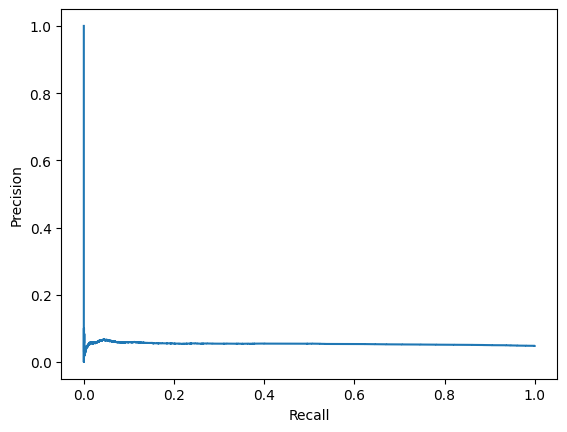

In [158]:
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()

In [161]:
def plot_metrics(
    c: str,
    y_true: pd.Series,
    y_pred: pd.Series,
    figure: tuple[matplotlib.figure.Figure, np.array] = None,
    lgd_msg: str = "",
):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    auc_score = auc(recall, precision)

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    if not figure:
        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    else:
        fig, ax = figure

    ax[0].plot(recall, precision, label=f"C used {c}; AUC={auc_score:.4f}; {lgd_msg}")
    ax[0].set_xlabel("Recall")
    ax[0].set_ylabel("Precision")
    ax[0].set_title("Precision-Recall curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"C used {c}; AUC={roc_auc:.4f}; {lgd_msg}")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC Curve")
    ax[1].legend()

Ridge

Creating model for C = 1, index 0


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Creating model for C = 0.1, index 1


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Creating model for C = 0.01, index 2


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Creating model for C = 0.001, index 3


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Creating model for C = 0.0001, index 4


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Creating model for C = 10, index 5


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


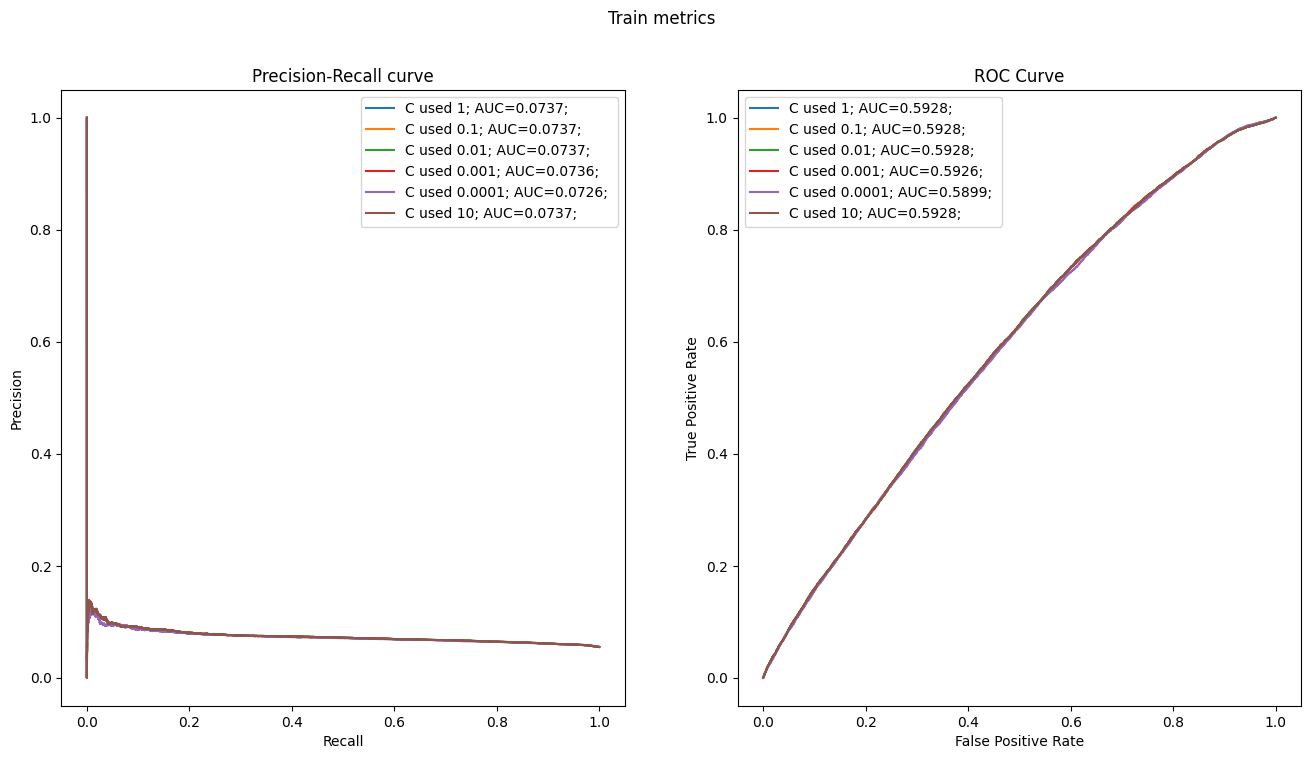

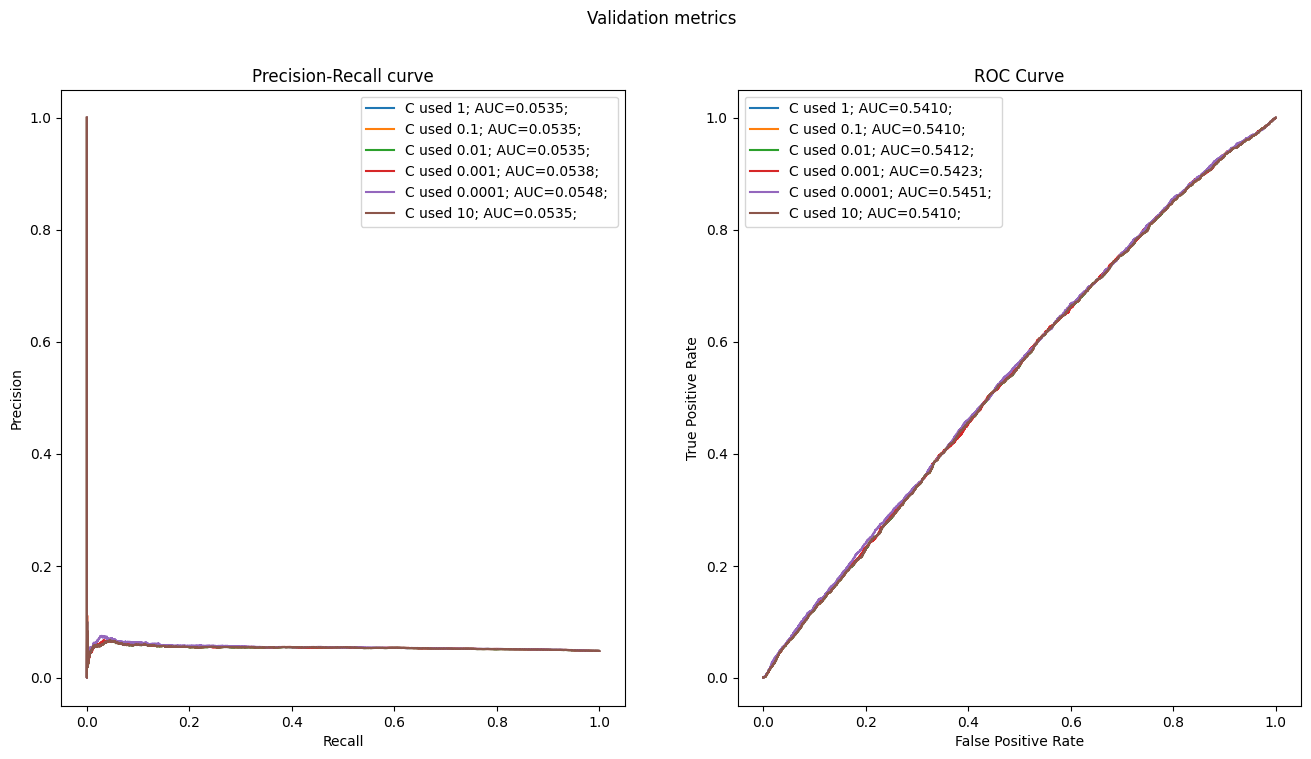

In [162]:
cs = [1, 0.1, 1e-2, 1e-3, 1e-4, 10]
fig1, axs1 = plt.subplots(1, 2, figsize=(16, 8))
fig1.suptitle("Train metrics")
fig2, axs2 = plt.subplots(1, 2, figsize=(16, 8))
fig2.suptitle("Validation metrics")


for index, c in enumerate(cs):
    print(f"Creating model for C = {c}, index {index}")
    pipe = make_pipeline(
        StandardScaler(), LogisticRegression(penalty="l2", C=c, solver="saga")
    )
    pipe.fit(X_train, y_train.values.ravel())
    train_y_pred = pipe.predict_proba(X_train)[:, 1]
    test_y_pred = pipe.predict_proba(X_test)[:, 1]
    plot_metrics(c, y_train, train_y_pred, (fig1, axs1))
    plot_metrics(c, y_test, test_y_pred, (fig2, axs2))

Lasso

Creating model for C = 1, index 0


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Creating model for C = 0.1, index 1


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Creating model for C = 0.01, index 2


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Creating model for C = 0.001, index 3


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Creating model for C = 0.0001, index 4
Creating model for C = 10, index 5


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


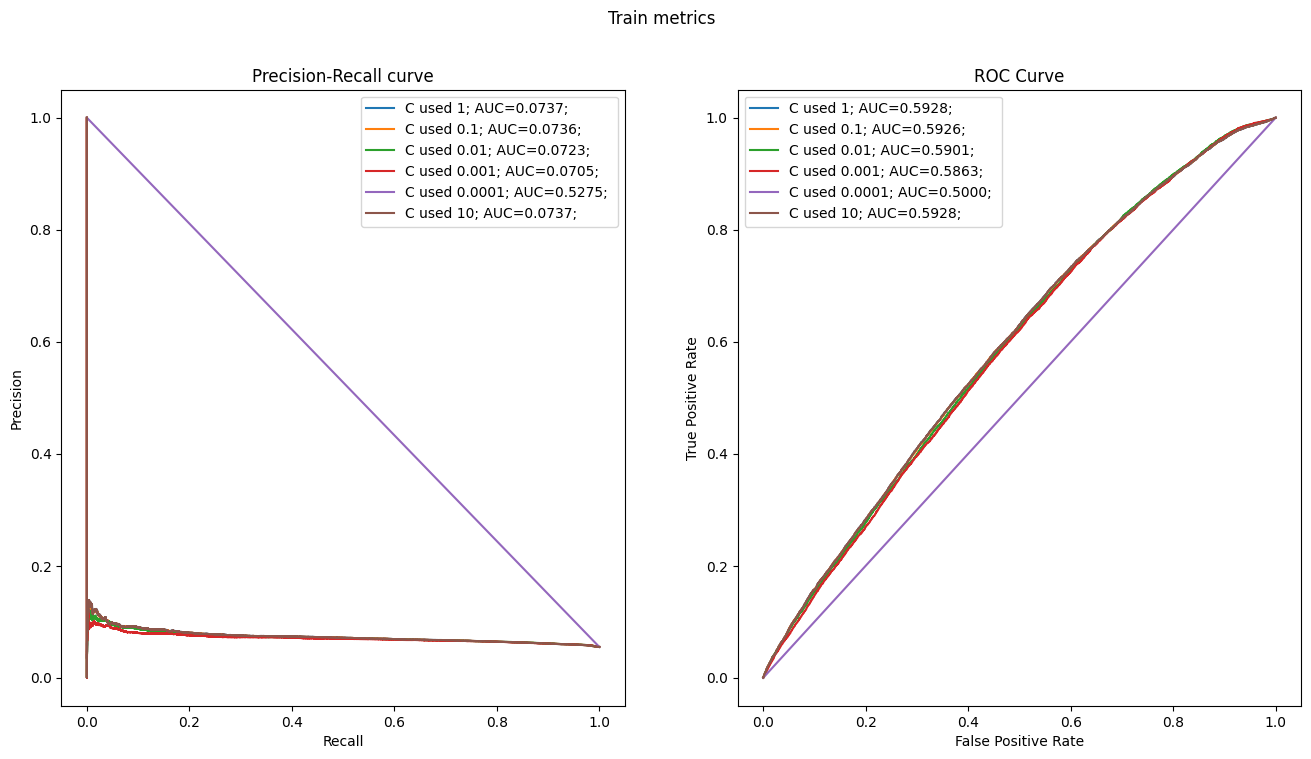

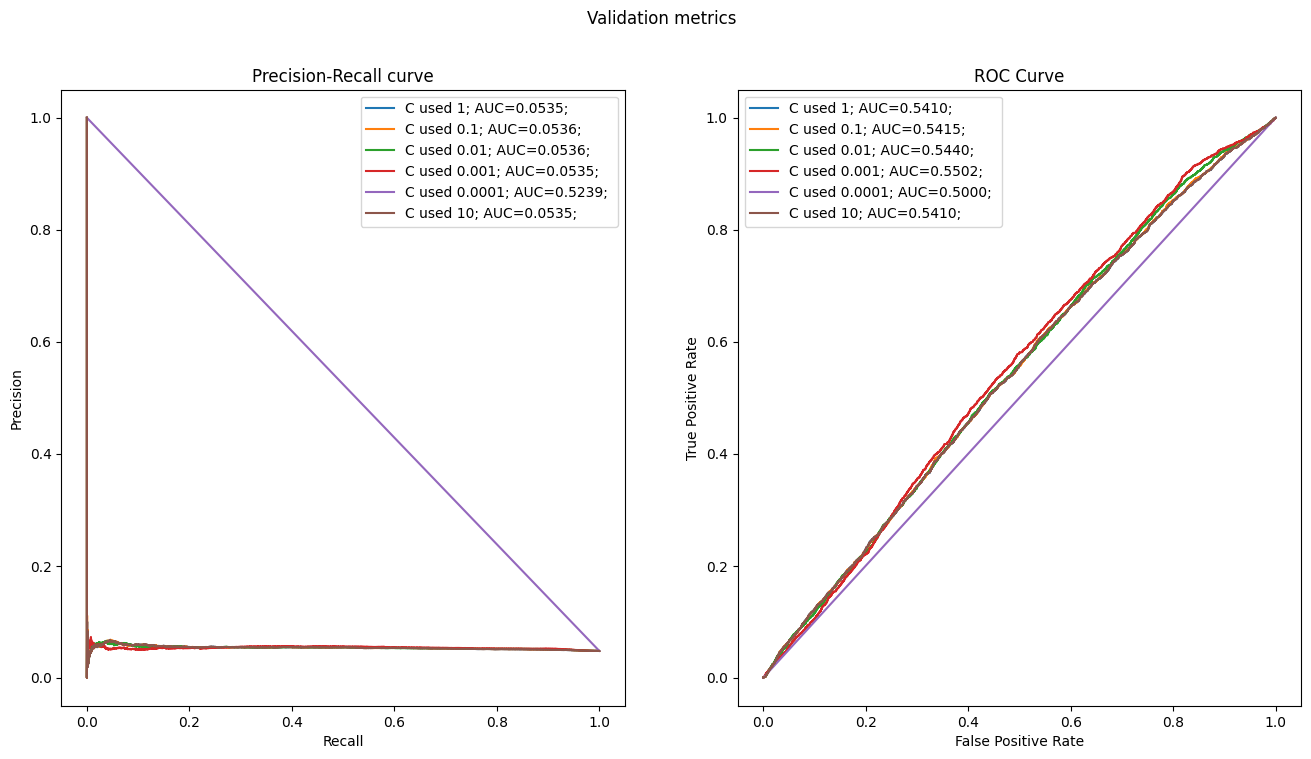

In [163]:
cs = [1, 0.1, 1e-2, 1e-3, 1e-4, 10]
fig1, axs1 = plt.subplots(1, 2, figsize=(16, 8))
fig1.suptitle("Train metrics")
fig2, axs2 = plt.subplots(1, 2, figsize=(16, 8))
fig2.suptitle("Validation metrics")


for index, c in enumerate(cs):
    print(f"Creating model for C = {c}, index {index}")
    pipe = make_pipeline(
        StandardScaler(), LogisticRegression(penalty="l1", C=c, solver="saga")
    )
    pipe.fit(X_train, y_train.values.ravel())
    train_y_pred = pipe.predict_proba(X_train)[:, 1]
    test_y_pred = pipe.predict_proba(X_test)[:, 1]
    plot_metrics(c, y_train, train_y_pred, (fig1, axs1))
    plot_metrics(c, y_test, test_y_pred, (fig2, axs2))

/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<Axes: xlabel='importance', ylabel='features'>

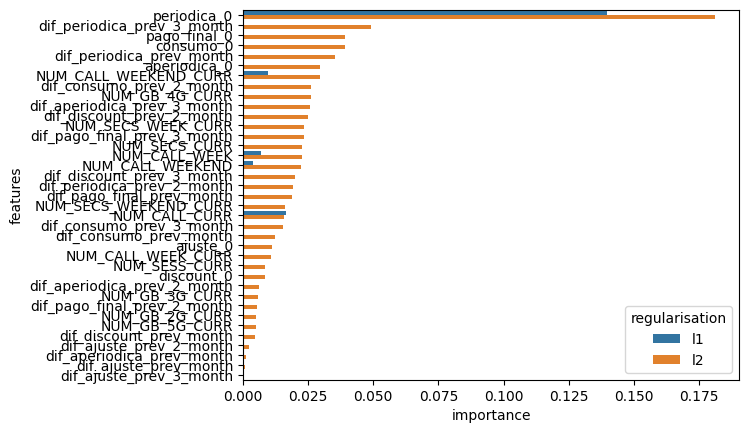

In [168]:
c = 0.001
pipe = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l1", C=c, solver="saga")),
    ]
)
pipe.fit(X_train, y_train)
pipe_coeffs_l1 = pd.DataFrame(
    {
        "features": X_train.columns,
        "importance": np.abs(pipe.named_steps["lr"].coef_[0]),
        "regularisation": ["l1"] * len(X_train.columns),
    }
)
pipe_coeffs_l1.sort_values("importance", ascending=True)

pipe = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l2", C=c, solver="saga")),
    ]
)
pipe.fit(X_train, y_train)
pipe_coeffs_l2 = pd.DataFrame(
    {
        "features": X_train.columns,
        "importance": np.abs(pipe.named_steps["lr"].coef_[0]),
        "regularisation": ["l2"] * len(X_train.columns),
    }
)
pipe_coeffs_l2.sort_values("importance", ascending=True)

pipe_coeffs = pd.concat([pipe_coeffs_l1, pipe_coeffs_l2])
pipe_coeffs["features"] = pd.Categorical(pipe_coeffs["features"])
pipe_coeffs = pipe_coeffs.sort_values("importance")
order_columns = pipe_coeffs_l2.sort_values("importance", ascending=False)["features"]
sns.barplot(
    pipe_coeffs, x="importance", y="features", hue="regularisation", order=order_columns
)

Let's trying only using the 10 first variables

In [176]:
list(order_columns[15:])

['NUM_CALL_WEEKEND',
 'dif_discount_prev_3_month',
 'dif_periodica_prev_2_month',
 'dif_pago_final_prev_month',
 'NUM_SECS_WEEKEND_CURR',
 'NUM_CALL_CURR',
 'dif_consumo_prev_3_month',
 'dif_consumo_prev_month',
 'ajuste_0',
 'NUM_CALL_WEEK_CURR',
 'NUM_SESS_CURR',
 'discount_0',
 'dif_aperiodica_prev_2_month',
 'NUM_GB_3G_CURR',
 'dif_pago_final_prev_2_month',
 'NUM_GB_2G_CURR',
 'NUM_GB_5G_CURR',
 'dif_discount_prev_month',
 'dif_ajuste_prev_2_month',
 'dif_aperiodica_prev_month',
 'dif_ajuste_prev_month',
 'dif_ajuste_prev_3_month']

In [179]:
train_X_2 = X_train.drop(columns=list(order_columns[15:]))
test_X_2 = X_test.drop(columns=list(order_columns[15:]))

Creating model for C = 1, index 0


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Creating model for C = 0.1, index 1


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Creating model for C = 0.01, index 2


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Creating model for C = 0.001, index 3


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Creating model for C = 0.0001, index 4
Creating model for C = 10, index 5


/mnt/c/Users/tonbo/Documents/ZriveDS/zrive-ds-4q24-churn/.env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


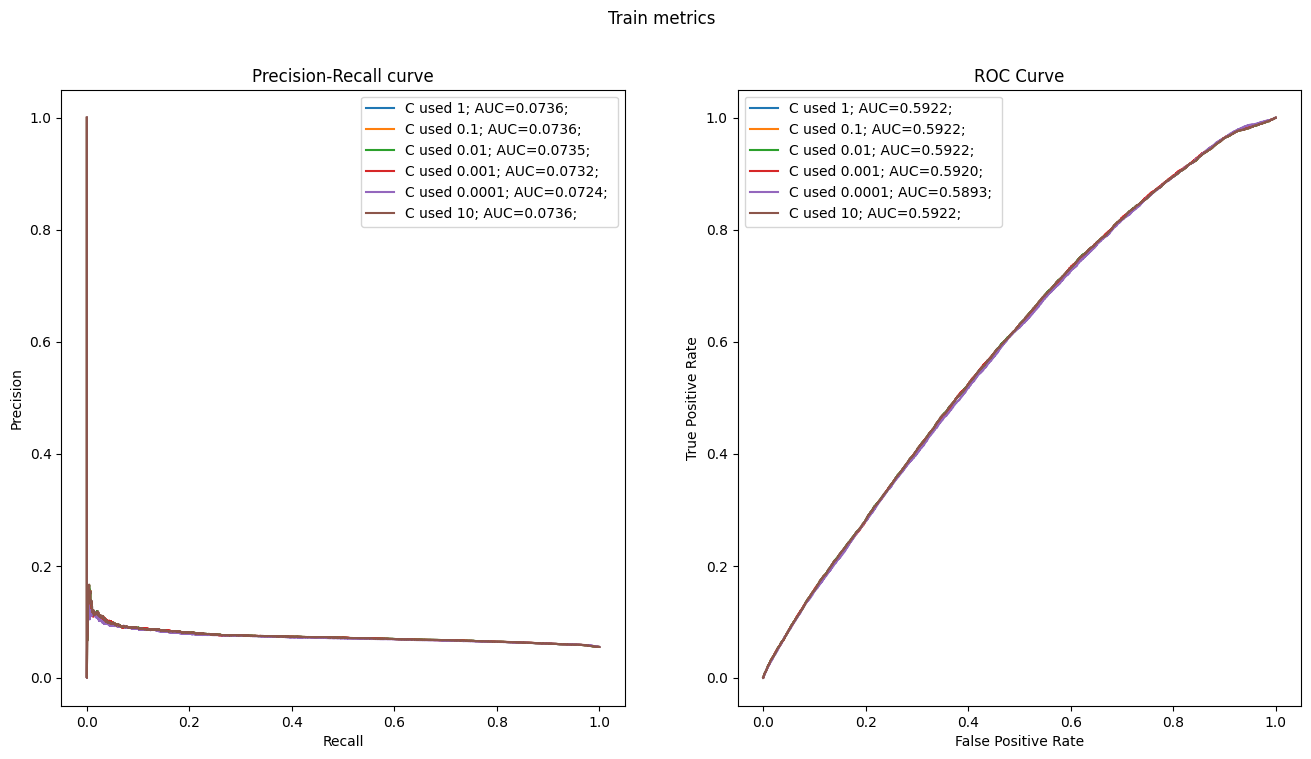

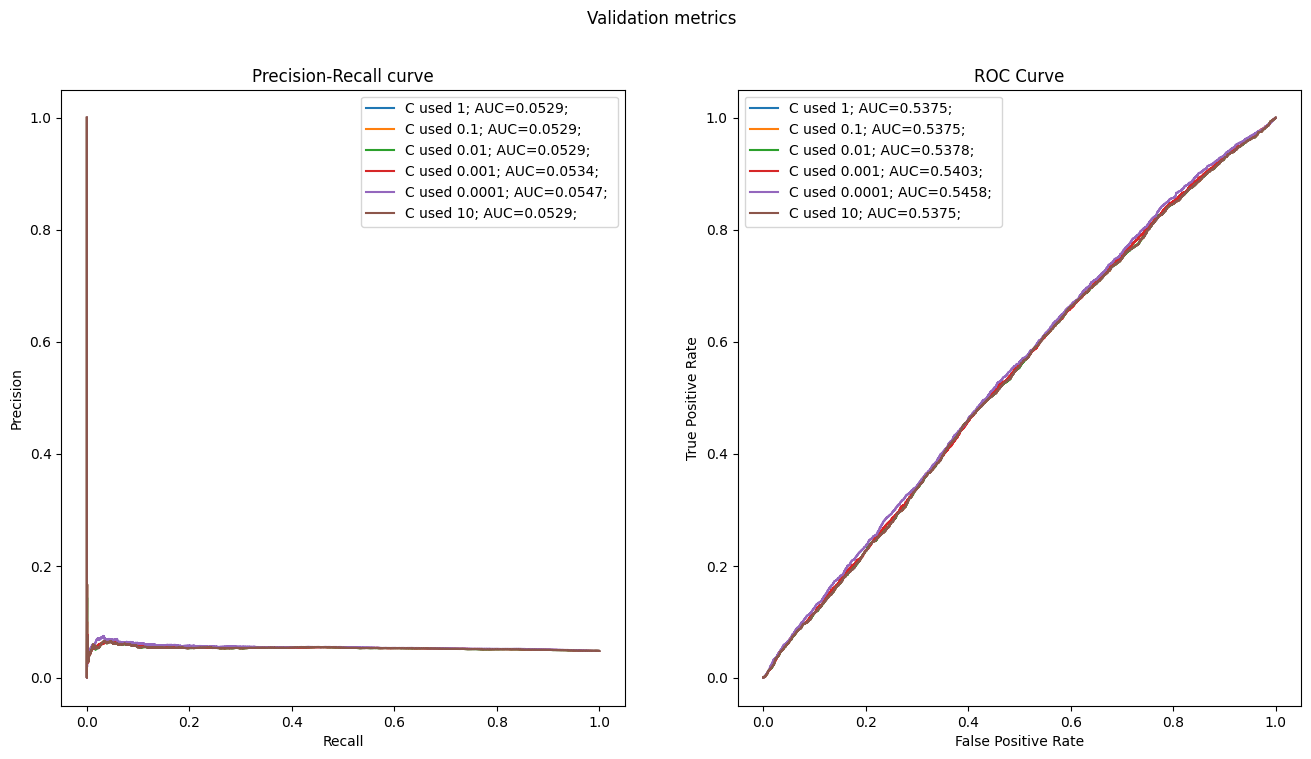

In [180]:
cs = [1, 0.1, 1e-2, 1e-3, 1e-4, 10]
fig1, axs1 = plt.subplots(1, 2, figsize=(16, 8))
fig1.suptitle("Train metrics")
fig2, axs2 = plt.subplots(1, 2, figsize=(16, 8))
fig2.suptitle("Validation metrics")


for index, c in enumerate(cs):
    print(f"Creating model for C = {c}, index {index}")
    pipe = make_pipeline(
        StandardScaler(), LogisticRegression(penalty="l2", C=c, solver="saga")
    )
    pipe.fit(train_X_2, y_train.values.ravel())
    train_y_pred = pipe.predict_proba(train_X_2)[:, 1]
    test_y_pred = pipe.predict_proba(test_X_2)[:, 1]
    plot_metrics(c, y_train, train_y_pred, (fig1, axs1))
    plot_metrics(c, y_test, test_y_pred, (fig2, axs2))

Let's test RandomForest

In [188]:
model = RandomForestClassifier(n_estimators=5)

model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=5)

In [192]:
y_pred = model.predict_proba(X_test)[:,1]

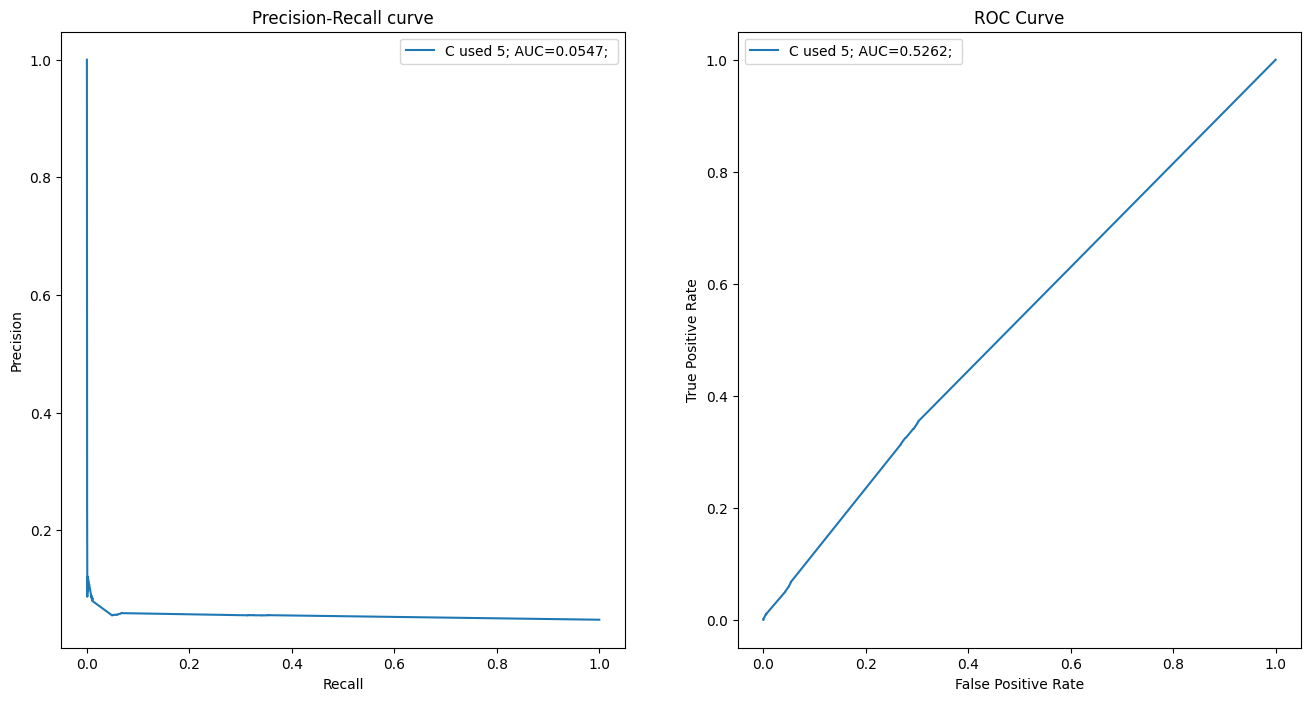

In [193]:
plot_metrics("5", y_test.values.ravel(), y_pred)

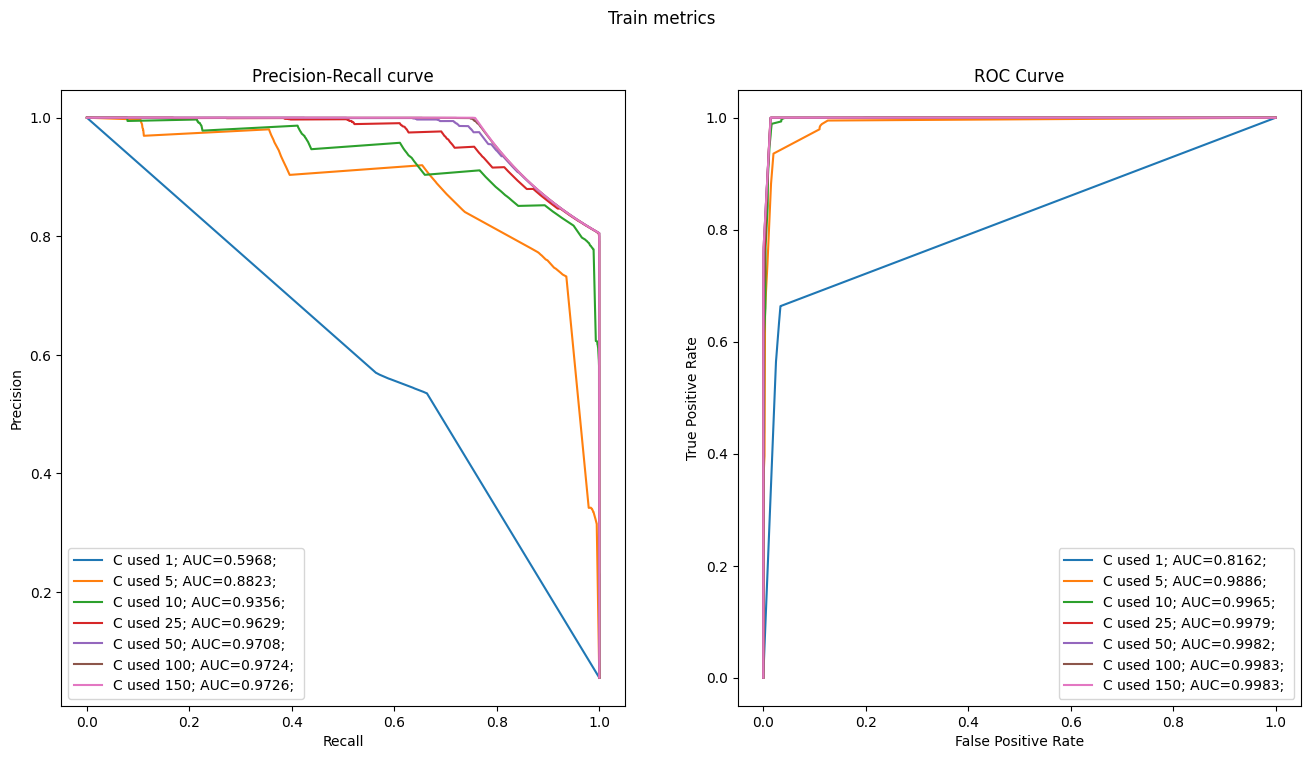

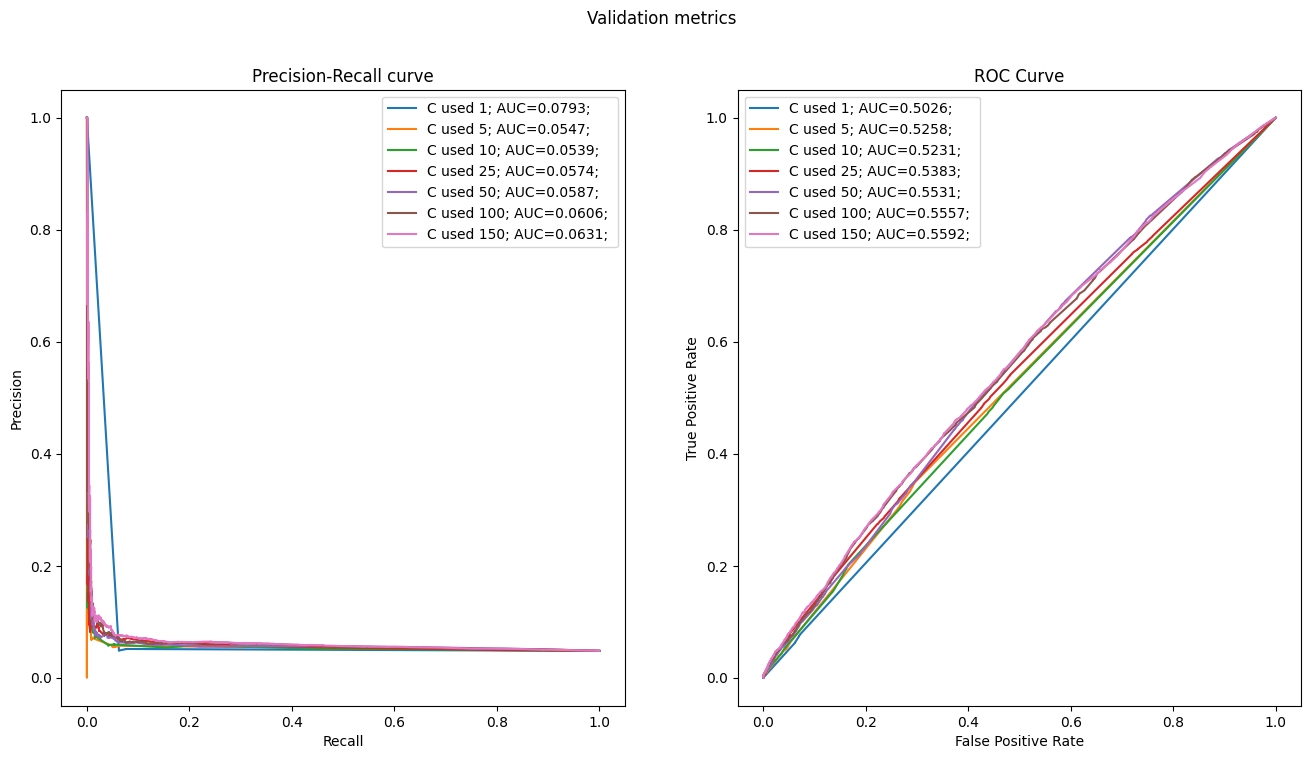

In [196]:
n_estimators = [1, 5, 10, 25, 50, 100, 150]
fig1, axs1 = plt.subplots(1, 2, figsize=(16, 8))
fig1.suptitle("Train metrics")
fig2, axs2 = plt.subplots(1, 2, figsize=(16, 8))
fig2.suptitle("Validation metrics")

for n in n_estimators:
    model = RandomForestClassifier(n_estimators=n)
    model.fit(X_train, y_train.values.ravel())
    train_y_pred = model.predict_proba(X_train)[:, 1]
    test_y_pred = model.predict_proba(X_test)[:, 1]
    plot_metrics(str(n), y_train, train_y_pred, (fig1, axs1))
    plot_metrics(str(n), y_test, test_y_pred, (fig2, axs2))

Let's see with less variables

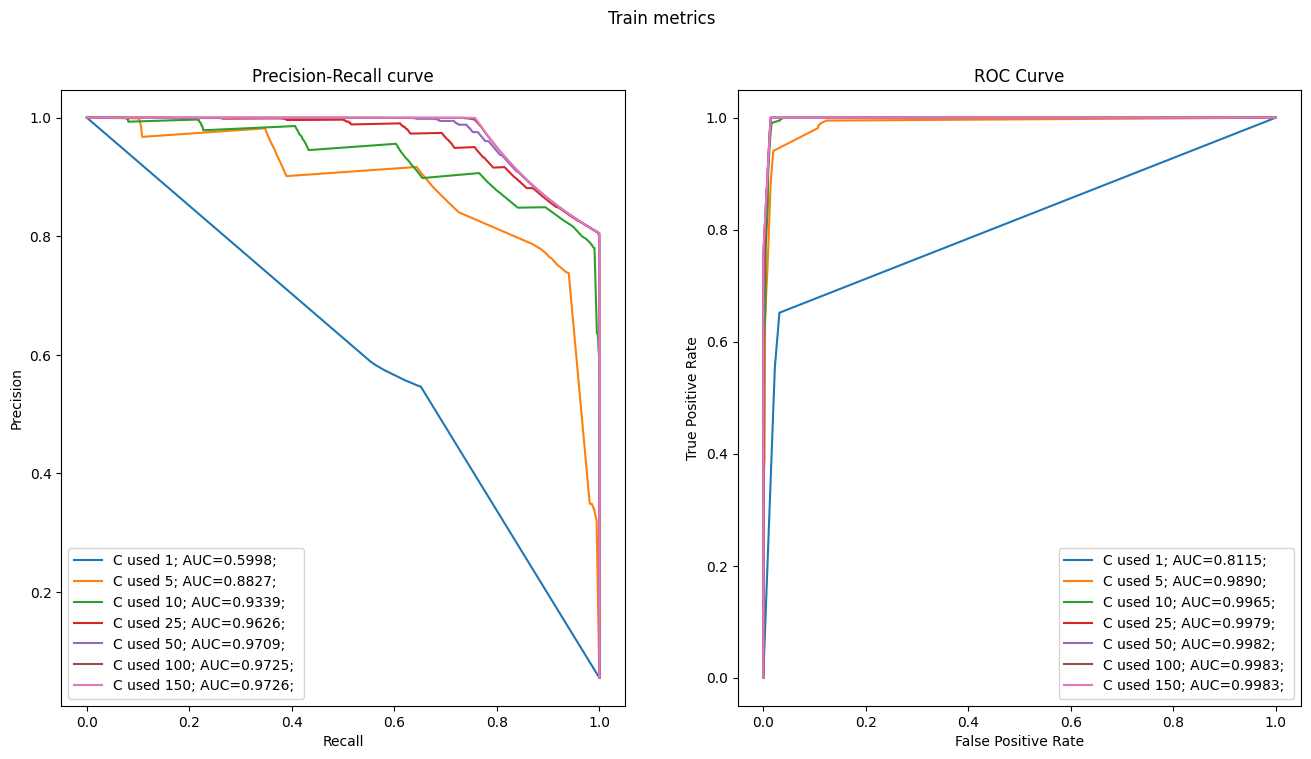

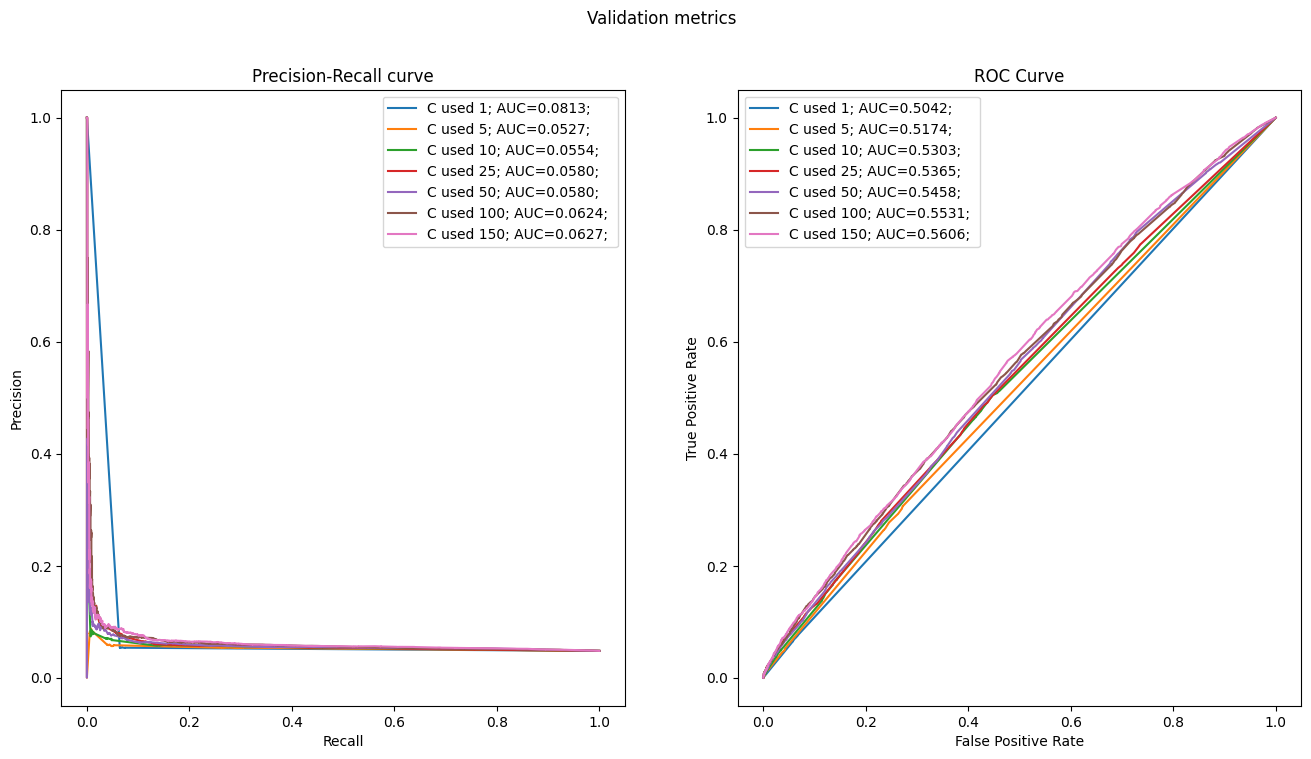

In [198]:
n_estimators = [1, 5, 10, 25, 50, 100, 150]
fig1, axs1 = plt.subplots(1, 2, figsize=(16, 8))
fig1.suptitle("Train metrics")
fig2, axs2 = plt.subplots(1, 2, figsize=(16, 8))
fig2.suptitle("Validation metrics")

for n in n_estimators:
    model = RandomForestClassifier(n_estimators=n)
    model.fit(train_X_2, y_train.values.ravel())
    train_y_pred = model.predict_proba(train_X_2)[:, 1]
    test_y_pred = model.predict_proba(test_X_2)[:, 1]
    plot_metrics(str(n), y_train, train_y_pred, (fig1, axs1))
    plot_metrics(str(n), y_test, test_y_pred, (fig2, axs2))